In [287]:
library(httr2)
library(ggplot2)

# Single day events to test functions with
author_births <- data.frame(
	name = c("Jamie", "Spandan", "Rex"),
	latitude = c(18.417, 22.6009, 24.9645),
	longitude = c(-64.6192, 88.4052, 121.2575),
	start_date = as.Date(c("1995-08-12", "1999-09-30", "1990-09-23")),
	end_date   = as.Date(c("1995-08-12", "1999-09-30", "1990-09-23")),
	stringsAsFactors = FALSE
)
row.names(author_births) <- author_births$name
author_births$name <- NULL

# Multi-day events to test functions with
canadian_olympics <- data.frame(
	city = c("Montreal", "Calgary", "Vancouver"),
	latitude = c(45.5088, 51.0447, 49.2827),
	longitude = c(-73.5618, -114.0719, -123.1207),
	start_date = as.Date(c("1976-07-17", "1988-02-13", "2010-02-12")),
	end_date   = as.Date(c("1976-08-01", "1988-02-28", "2010-02-28")),
	stringsAsFactors = FALSE
)
row.names(canadian_olympics) <- canadian_olympics$city
canadian_olympics$city <- NULL

# The hourly variables supported by this API wrapper
supported_hourly_variables <- c(
    "temperature_2m",
    "rain",
    "snowfall",
    "wind_speed_10m",
    "relative_humidity_2m",
    "snow_depth",
    "cloud_cover"
)

# The daily variables supported by this API wrapper
supported_daily_variables <- c(
    "temperature_2m_max", 
    "temperature_2m_min", 
    "daylight_duration", 
    "sunshine_duration", 
    "rain_sum", 
    "snowfall_sum", 
    "precipitation_hours", 
    "wind_speed_10m_max"
)

# Function to get the response from the Open-Meteo API 
get_historical_weather_raw <- function(
	latitude,
	longitude,
	start_date,
	end_date,
    daily_variables = c(),
	hourly_variables = c()
) {

    # TODO: Error handling. Validate latitude is between -90 and 90
    # TODO: Error handling. Validate longitude is between -180 and 180
    # TODO: Error handling. Validate start_date is after 1940-01-01
    # TODO: Error handling. Validate end_date is over 5 days ago
    # TODO: Error handling. Validate start_date is before end_date

    # Calling the Open-Meteo Api
	req <- req_url_query(
		request("https://archive-api.open-meteo.com/v1/archive"),
		latitude = latitude,
		longitude = longitude,
		start_date = start_date,
		end_date   = end_date,
        daily = paste(daily_variables, collapse = ","),
		hourly = paste(hourly_variables, collapse = ",")
	)

    # TODO: Error handling. For resp_status(resp) != 200

	response <- req_perform(req)
    response
}

# Function to get daily historical weather data as a dataframe
get_historical_weather_daily <- function(
	latitude,
	longitude,
	start_date,
	end_date,
	daily_variables = supported_daily_variables
) {

    # TODO: Error handling. Validate every daily variable is in supported_daily_variables

	response <- get_historical_weather_raw(
        latitude = latitude,
		longitude = longitude,
		start_date = start_date,
		end_date = end_date,
        daily_variables = daily_variables
    )
    
	data_json <- resp_body_json(response)
    daily_data <- as.data.frame(lapply(data_json$daily, function(x) unlist(x))) # Making each daily variable a column in the dataframe
    daily_data$time <- as.Date(daily_data$time, format = "%Y-%m-%d") # Making time a date column in the dataframe
    daily_data
}

# Function to get hourly historical weather data as a dataframe
get_historical_weather_hourly <- function(
	latitude,
	longitude,
	start_date,
	end_date,
	hourly_variables = supported_hourly_variables
) {

    # TODO: Error handling. Validate every hourly variable is in supported_hourly_variables

	response <- get_historical_weather_raw(
        latitude = latitude,
		longitude = longitude,
		start_date = start_date,
		end_date = end_date,
        hourly_variables = hourly_variables
    )
    
	data_json <- resp_body_json(response)
    hourly_data <- as.data.frame(lapply(data_json$hourly, function(x) unlist(x))) # Making each hourly variable a column in the dataframe
    hourly_data$time <- as.POSIXct(hourly_data$time, format = "%Y-%m-%dT%H:%M", tz = "UTC") # Making time a datetime column in the dataframe
    hourly_data
}

# Function to get the units for all supported daily variables
get_supported_daily_units <- function() {

    # An arbitrary location and time, just to get variable units from API
    daily_data <- get_historical_weather_raw(
    	49.2593,
    	123.2475,
    	"2020-01-01",
    	"2020-01-01",
        daily = supported_daily_variables
    )
    
    resp_body_json(daily_data)$daily_units
}

# Function to get the units for all supported hourly variables
get_supported_hourly_units <- function() {

    # An arbitrary location and time, just to get variable units from API
    hourly_data <- get_historical_weather_raw(
    	49.2593,
    	123.2475,
    	"2020-01-01",
    	"2020-01-01",
        hourly = supported_hourly_variables
    )
    
    resp_body_json(hourly_data)$hourly_units
}   

# Function to visualize trends in historical weather
plot_feature <- function(dataframe, feature) {

    # TODO: Error handling. Validate feature and time is in dataframe
    
    ggplot(dataframe, aes(x = time, y = .data[[feature]])) +
    	geom_line(color = "yellow") +
    	geom_point(color = "yellow") +
    	labs(x = "Time", y = "Value", title = feature) +
    	theme_dark()
}

In [289]:
author_births

,latitude,longitude,start_date,end_date
,<dbl>,<dbl>,<date>,<date>
Jamie,18.4170,-64.6192,1995-08-12,1995-08-12
Spandan,22.6009,88.4052,1999-09-30,1999-09-30
Rex,24.9645,121.2575,1990-09-23,1990-09-23


In [288]:
canadian_olympics

,latitude,longitude,start_date,end_date
,<dbl>,<dbl>,<date>,<date>
Montreal,45.5088,-73.5618,1976-07-17,1976-08-01
Calgary,51.0447,-114.0719,1988-02-13,1988-02-28
Vancouver,49.2827,-123.1207,2010-02-12,2010-02-28


In [297]:
vancouver_olympics <- canadian_olympics["Calgary", ]

daily_data <- get_historical_weather_daily(
	vancouver_olympics$latitude,
	vancouver_olympics$longitude,
	vancouver_olympics$start_date,
	vancouver_olympics$end_date
)

head(daily_data, 20)

,time,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1988-02-13,7.2,-4.5,35558.99,20271.74,0.0,0.00,0,25.6
2,1988-02-14,4.0,-10.0,35776.29,22398.88,0.0,0.49,6,14.6
3,1988-02-15,4.6,-1.5,35995.80,26404.72,0.0,0.00,0,36.2
4,1988-02-16,3.1,-9.1,36217.30,27446.04,0.0,0.00,0,20.5
5,1988-02-17,1.5,-2.2,36440.57,4604.91,0.0,0.28,1,28.2
6,1988-02-18,5.4,-6.5,36665.40,28025.48,0.0,0.00,0,19.9
7,1988-02-19,9.5,-0.1,36891.58,23224.74,0.0,0.00,0,23.8
8,1988-02-20,14.3,2.0,37118.89,32006.67,0.0,0.00,0,23.8
9,1988-02-21,10.9,1.3,37347.16,33262.45,0.0,0.00,0,35.2


In [298]:
hourly_data <- get_historical_weather_hourly(
	vancouver_olympics$latitude,
	vancouver_olympics$longitude,
	vancouver_olympics$start_date,
	vancouver_olympics$end_date,
)

head(hourly_data, 20)

,time,temperature_2m,rain,snowfall,wind_speed_10m,relative_humidity_2m,snow_depth,cloud_cover
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>
1,1988-02-13 00:00:00,7.2,0,0,4.6,51,0.07,98
2,1988-02-13 01:00:00,3.2,0,0,7.0,68,0.07,100
3,1988-02-13 02:00:00,1.9,0,0,7.2,65,0.07,100
4,1988-02-13 03:00:00,3.2,0,0,5.2,58,0.07,99
5,1988-02-13 04:00:00,3.1,0,0,6.2,57,0.07,100
6,1988-02-13 05:00:00,-0.7,0,0,9.1,69,0.07,100
7,1988-02-13 06:00:00,0.9,0,0,9.0,63,0.07,100
8,1988-02-13 07:00:00,-3.0,0,0,8.5,74,0.07,100
9,1988-02-13 08:00:00,-3.8,0,0,8.7,77,0.07,100


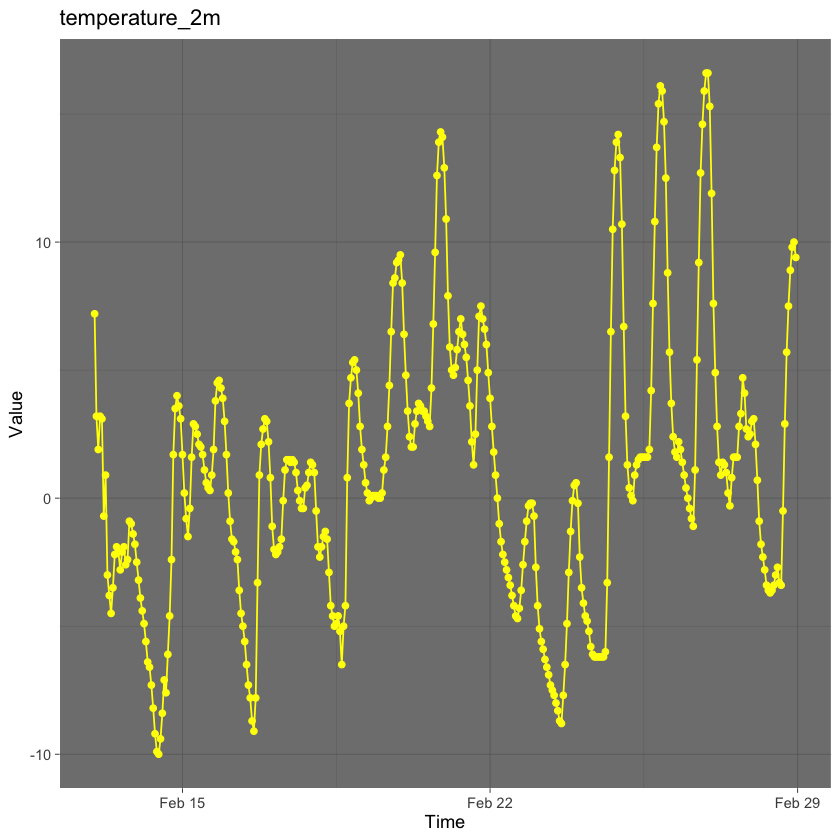

In [299]:
plot_feature(hourly_data, "temperature_2m")